In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sobel_canny_detector import *
import pickle
import matplotlib.pyplot as plt

# Load dataset & Preprocessing
Load the ASL train dataset from the local directory, and preprocess the images with sobel-canny-combination edge detection.

In [3]:
# Crop outline of image by padding size
def crop_image(image, padding=8):
  height, width, _ = image.shape
  crop_size = min(height - padding, width - padding)
  x = (width - crop_size) // 2
  y = (height - crop_size) // 2
  cropped = image[y:y + crop_size, x:x + crop_size]
  return cropped

def preprocess_sign_image(image):
  image = crop_image(image)
  image = cv2.resize(image, (224, 224))
  _, image = apply_sobel_canny_detection(image)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  image = image.astype(np.float32) / 255.0
  return image

In [4]:
data_generator = ImageDataGenerator(
  preprocessing_function=preprocess_sign_image,
  fill_mode='nearest',
  validation_split=0.2
)

In [5]:
image_size = (224, 224)
batch_size = 32

train_dataset = data_generator.flow_from_directory(
  './images/asl_alphabet_train/',
  target_size=image_size,
  batch_size=batch_size,
  class_mode='categorical',
  subset='training'
)
validation_dataset = data_generator.flow_from_directory(
  './images/asl_alphabet_train/',
  target_size=image_size,
  batch_size=batch_size,
  class_mode='categorical',
  subset='validation'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


# AlexNet(CNN) Model
AlexNet is a variant of CNN(Convolutional Neural Network) model which is capable to detect pattern in the given image and help to classify it.

In [6]:
# Define the AlexNet model
model = keras.Sequential()
model.add(Input((224, 224, 3)))

# Layer 1
model.add(Conv2D(96, 11, strides=4, padding='same'))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))

# Layer 2
model.add(Conv2D(256, 5, strides=4, padding='same'))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))

# Layer 3
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))

# Layer 4
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))

# Layer 5
model.add(Conv2D(256, 3, strides=4, padding='same'))
model.add(Activation('relu'))

# Flatten the output from convolutional layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(29, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 56, 56, 96)        0         
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                                 
 lambda_1 (Lambda)           (None, 7, 7, 256)         0         
                                                        

# Train the Model

In [7]:
epochs = 10
batch_size = 32

history = model.fit(
  train_dataset,
  steps_per_epoch=len(train_dataset),
  epochs=epochs,
  batch_size=batch_size,
  validation_data=validation_dataset,
  validation_steps=len(validation_dataset),
  verbose=2
)

Epoch 1/10
2175/2175 - 1694s - loss: 3.3682 - accuracy: 0.0338 - val_loss: 3.3674 - val_accuracy: 0.0345 - 1694s/epoch - 779ms/step
Epoch 2/10
2175/2175 - 1012s - loss: 3.3677 - accuracy: 0.0331 - val_loss: 3.3674 - val_accuracy: 0.0345 - 1012s/epoch - 465ms/step
Epoch 3/10
2175/2175 - 1008s - loss: 3.3677 - accuracy: 0.0334 - val_loss: 3.3674 - val_accuracy: 0.0345 - 1008s/epoch - 463ms/step
Epoch 4/10
2175/2175 - 1015s - loss: 3.3677 - accuracy: 0.0337 - val_loss: 3.3674 - val_accuracy: 0.0345 - 1015s/epoch - 467ms/step
Epoch 5/10
2175/2175 - 990s - loss: 3.3676 - accuracy: 0.0336 - val_loss: 3.3674 - val_accuracy: 0.0345 - 990s/epoch - 455ms/step
Epoch 6/10
2175/2175 - 981s - loss: 3.3677 - accuracy: 0.0325 - val_loss: 3.3673 - val_accuracy: 0.0345 - 981s/epoch - 451ms/step
Epoch 7/10
2175/2175 - 1013s - loss: 3.3676 - accuracy: 0.0337 - val_loss: 3.3674 - val_accuracy: 0.0345 - 1013s/epoch - 466ms/step
Epoch 8/10
2175/2175 - 1003s - loss: 3.3677 - accuracy: 0.0327 - val_loss: 3.367

In [8]:
# Save the trained model
model_name = 'sobel-canny_alexnet_10epochs_32batch'
model.save(f'./models/{model_name}.h5')

# Save the history
with open(f'./training_history/{model_name}.pkl', 'wb') as file:
  pickle.dump(history.history, file)

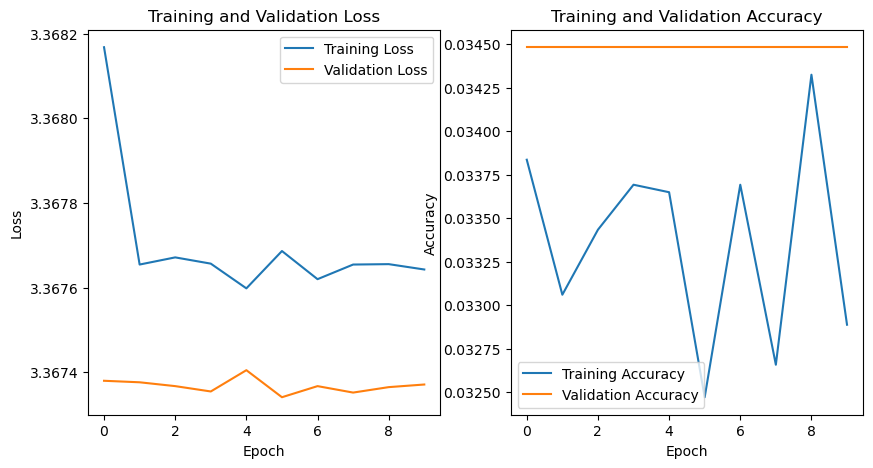

In [9]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()